# Probabilistic Linear Ensembles 

#TODO: Come back and add the problem description

---

## Define Ensemble Performance Metrics

#TODO: Come back add add notes after analysis


## Analyze Data and Engineer Features

#TODO: Come back and add notes after analysis

In [2]:
# %%
import numpy as np
import pandas as pd
import xarray as xr
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf

az.style.use('arviz-darkgrid')

np.random.seed(101)

In [3]:
# Import financial returns data

# Specify timeseries
start = datetime(2022, 11, 15)
end = datetime(2022, 12, 31)

# Import historical data for AAPL, SPY, and ^TNX
market = yf.Ticker("SPY").history(start=start, end=end)
stock = yf.Ticker("AAPL").history(start=start, end=end)
riskfree_rate = yf.Ticker("^TNX").history(start=start, end=end)

In [ ]:

# %%
# Create dataframe for securities where the returns will be based on daily
# percent changes from the previous day
daily_returns = pd.DataFrame()

daily_returns["market"] = market["Close"].pct_change(1)*100
daily_returns["stock"] = stock["Close"].pct_change(1)*100

# We need to reset the index for the risk free rate dataframe or else it
# will be all NaN values in the oberservations
riskfree_rate.index = daily_returns.index
daily_returns["riskfree"] = riskfree_rate["Close"].pct_change(1)*100

# Check for missing data in the dataframe (good practice)
market.index.difference(riskfree_rate.index)

# Fill rows with previous day's risk-free rate since they're generally stable,
# do this as a sanity check as it's good practice to make sure we're not
# going to be missing any data which can mess up an analysis
daily_returns = daily_returns.ffill()

# Drop NaNs in first row since they can't be computed the way we want them
daily_returns = daily_returns.dropna()

# Check for null values
print(f"Null values:\n{daily_returns.isnull().sum()}")

daily_returns.head()

In [ ]:
# %%
# Use the imported data to create our training data (X,Y) where
# X = (Realized returns - Risk free rate) and Y = (Market returns - Risk free rate)
x = daily_returns["stock"] - daily_returns["riskfree"]
y = daily_returns["market"] - daily_returns["riskfree"]

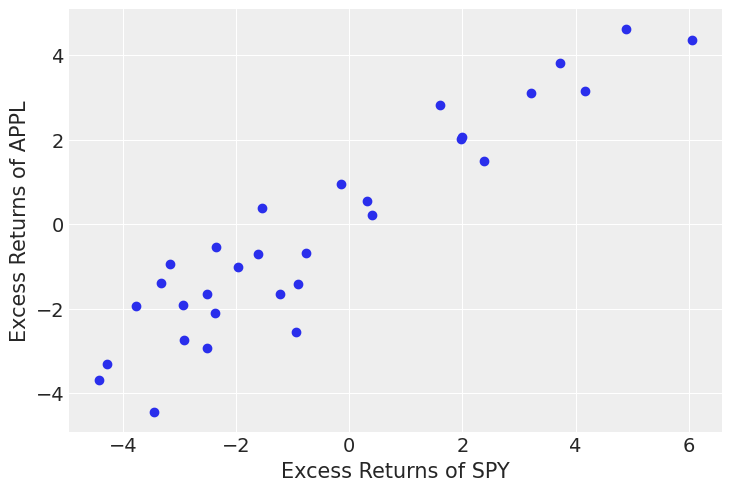

In [6]:
# %%
# Visualize excess returns of AAPL and SPY
plt.scatter(x, y)
plt.ylabel("Excess Returns of APPL")
plt.xlabel("Excess Returns of SPY")
plt.show()

Observe the apparently linear relationship between AAPL and SPY returns. 

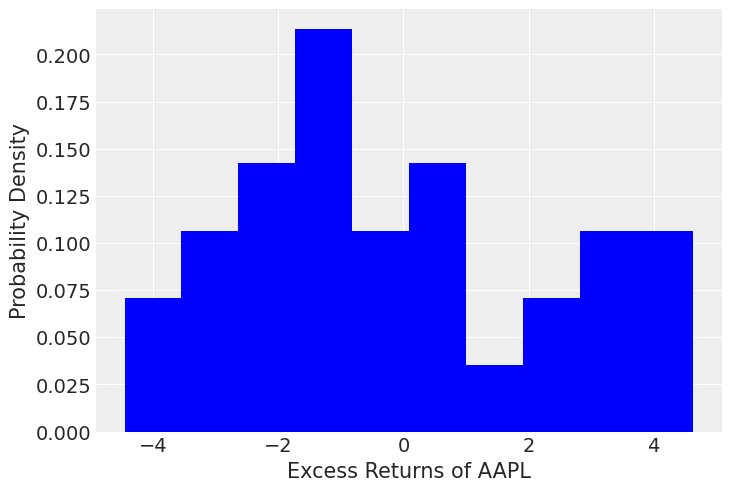

In [7]:

# Plot histogram of AAPL excess returns.
plt.hist(y, density=True, color="blue")
plt.ylabel("Probability Density")
plt.xlabel("Excess Returns of AAPL")
plt.show()


In [8]:
# %%
# Analyze daily excess returns of all securities during time period
daily_returns.describe()

,market,stock,riskfree
count,31.000000,31.000000,31.000000
mean,-0.110989,-0.444418,0.087442
std,1.192475,1.967493,2.038117
min,-2.446174,-4.685405,-4.698893
25%,-0.805429,-1.775161,-1.360752
50%,-0.171759,-0.343494,0.183341
75%,0.602692,0.635448,1.705280
max,3.150067,4.859367,2.905891


In [9]:
# Finally, getting to the goal. Now that we've gotten the data, checked it
# out a little bit and are satisfied with it, let's use it for our training
# data while also setting aside some of the data for testing.
# We'll do this by splitting the time series sequentially. This is due
# to serial correlation in financial data.

# This is a small sample of data, so let's only set aside 10 observations
# for testing data.
test_size = 10

x_train = x[:-test_size]
y_train = y[:-test_size]

x_test = x[-test_size:]
y_test = y[-test_size:]

#TODO: Come back and add notes for this phase of the model development.

In [12]:
"""
Phase: Develop and Retrodict Prior Ensemble

First we'll specify distributions and their parameters for our priors and 
likelihood. This means that we're incorporating our knowledge into the 
ensemble by specifying the prior probability distributions of its parameters,
P(alpha), P(beta), P(epsilon).

We'll also specify the likelihood of observing our data given the parameters,
P(D | alpha, beta, epsilon).

Recall, during the model design phase, we decided that our likelihood function
will follow a Student's T distribution with dof equal to 6 (from empirical)
financial data analysis.
"""
# Create a probabilistic model by instantiating the PyMC model class
model = pm.Model()

In [13]:


#%%
# After instantiating a PyMC model instace, we can use Python's with 
# statement to create a context manager that will automatically handle the 
# setup and teardown phases of the object
with model:
    # Define the prior probability distributions of the model's parameters 
    # using our prior knolwedge (refer back to the lab manual for the 
    # specification of these prior parameter distributions

    # Recall that alpha in the market model represents the idiosyncratic, daily
    # excess returns of APPL which is unaffected by market movements.
    # In the model design phase, we specified that we assume alpha to be normally
    # distributed where the parameters are based on previous data analysis and 
    # trial and error.
    alpha = pm.Normal("alpha", mu = 0.02, sigma = 0.10)
    
    # Recall, beta quantifies the sensitivity of APPL to the movements of 
    # the market, in this case proxied by SPY. We assumed this parameter to 
    # be normally distributed with values of mu and sigma based on previous
    # data analysis and trial and error.
    beta = pm.Normal("beta", mu = 1.2, sigma = 0.15)

    # The residual quantifies the unexpected returns of AAPL which means the
    # returns that are not predicted by our linear model. We specified during
    # the design phase that we want this distribution to follow a half T with 
    # nu = 6, which is based on research students and trial and error
    residual = pm.HalfStudentT("residual", sigma = 0.20, nu = 6)

    # Create "mutable data containers" that allow use to easily swap out data
    # we'll use for out model. For now, we'll start by using our training 
    # data which we'll swap out for out testing data later.
    feature = pm.Data("feature", x_train, dims = "feature_data")
    target = pm.Data("target", y_train, dims = "target_data")

    # The expected daily returns of AAPL are approximately linearly related to
    # daily excess returns of SPY. We'll define this as a deterministic linear
    # model. This is the deterministic model that we're attemtping to create 
    # a probabilistic version for?...
    target_expected = pm.Deterministic("target_expected", 
                      alpha + beta * feature, dims = "feature_data")

    # Now, we'll assign the training data sample to the likelihood function.
    # Daily excess stock price returns are assumed to be T-distributed with nu = 6
    target_likelihood = pm.StudentT("target_likelihood", mu = target_expected,
        sigma = residual, nu = 6, observed = target, dims = "target_data")

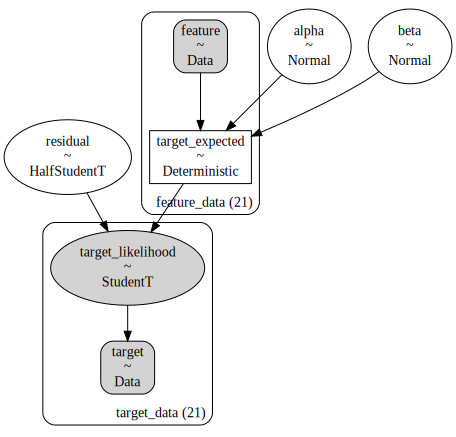

In [14]:

#%%
# We can use the graphviz method to visualize the probabilistic model's 
# data, parameters, distributions, and dependencies
pm.model_to_graphviz(model)


In [15]:


#%%
# Next, we'll sample distributions and simulate data before we train our model
# to check the usefulness of the assumptions of our prior ensemble.
# We do this by conducting a prior predictive check using the ensemble's prior
# predictive distribution to simulate a data distribution that may have been 
# realized in the past (still confused as to wtf this means...).

# To do this, we'll simulate 21,000 data samples from the prior predictive
# distribution and then visualize/analyze the generated data samples.

# Sample from the prior distributions and the likelihood function to generate
# prior predicitve distribution of the model.
# Take 1000 draws from the prior predictive distribution to simulate (1000*21)
# target values based on our prior assumptions. 
idata = pm.sample_prior_predictive(samples = 1000, model = model, 
                        return_inferencedata = True, random_seed = 101)

# Ok, so idata contains the inferences from sampling from the prior 
# distribution of the model.
idata

Sampling: [alpha, beta, residual, target_likelihood]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data